In [5]:
# ============================================
# 0. IMPORT & INSTALL LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import os
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Install libraries
!pip install pdfplumber python-docx spacy --quiet
!python -m spacy download en_core_web_sm --quiet

import pdfplumber
import docx
import spacy

# Download NLTK resources
for pkg in ['punkt', 'punkt_tab', 'stopwords']:
    nltk.download(pkg, quiet=True)
from nltk.corpus import stopwords

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# ============================================
# I. FILE READER
# ============================================

def read_cv_file(file_path):
    ext = os.path.splitext(file_path)[-1].lower()
    text = ""
    if ext == ".pdf":
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
    elif ext == ".docx":
        doc = docx.Document(file_path)
        for para in doc.paragraphs:
            text += para.text + "\n"
    elif ext == ".txt":
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
    else:
        raise ValueError("❌ Unsupported file format")
    return text.strip()

def read_dataset_csv(file_path):
    df = pd.read_csv(file_path)
    print(f"✅ Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
    return df

def clean_skill(s):
    s = s.strip().lower()
    # Bỏ rỗng
    if not s:
        return None
    # Giữ đặc biệt C, R, Go, .net
    special_keep = {'c', 'r', 'go', '.net'}
    if s in special_keep:
        return s
    # Bỏ số hoặc chỉ ký hiệu
    if re.fullmatch(r"[\d\.\-]+", s):
        return None
    # Bỏ từ 1 ký tự
    if len(s) < 2:
        return None
    # Bỏ stopwords cơ bản
    stopwords = {"and", "or", "to", "of", "in", "on", "a", "an", "the", "for"}
    if s in stopwords:
        return None
    return s


# ============================================
# II. SKILL LIST (From multiple sources)
# ============================================
SKILL_LIST = {
    "data structures", "algorithms", "python", "java", "c++", "c#", "rust",
    "javascript", "typescript", "html", "css", "php", "ruby", "go", "swift",
    "git", "version control", "testing", "unit testing", "database",
    "mysql", "postgresql", "mongodb", "cloud computing", "aws", "azure",
    "docker", "kubernetes", "ci/cd", "devops", "machine learning",
    "deep learning", "nlp", "cybersecurity", "web development",
    "mobile development", "android", "ios", "data analysis", "sql",
    "problem solving", "linux", "shell scripting"
}

try:
    # Lọc từ skill2vec_10K.csv
    url = "https://raw.githubusercontent.com/duyet/skill2vec-dataset/master/skill2vec_10K.csv"
    df_skills = pd.read_csv(url, header=None, low_memory=False).iloc[:, 1:]
    skill2vec_clean = sorted(
        {clean_skill(str(skill)) for skill in df_skills.stack() if pd.notnull(skill)}
        - {None}
    )
    print(f"Tổng skill sạch: {len(skill2vec_clean)}")

except Exception as e:
    print(f"⚠ Không thể load skill2vec_10K.csv: {e}")
    skill2vec_set = ["python", "java", "sql", "git", "javascript"]  # fallback

# Merge vào SKILL_LIST
#SKILL_LIST = set(SKILL_LIST).union(set(skill2vec_clean)) #-> IN-PROGRESS
print(f"✅ Tổng kỹ năng sau khi merge: {len(SKILL_LIST)}")


# ============================================
# III. AUTO STOP WORDS VIA TF-IDF
# ============================================

def get_auto_stopwords_from_dataset(documents, top_n=20):
    """
    🔹 Phát hiện stop words tự động dựa vào IDF
    documents: list chứa nội dung văn bản (mỗi CV 1 string)
    top_n: số lượng từ ít giá trị phân biệt nhất (IDF thấp nhất)
    """
    vectorizer = TfidfVectorizer(lowercase=True)
    tfidf_matrix = vectorizer.fit_transform(documents)
    idf_values = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
    stop_words_auto = sorted(idf_values, key=idf_values.get)[:top_n]
    return set(stop_words_auto)

# ============================================
# IV. TEXT PROCESSING PIPELINE
# ============================================

def advanced_text_processing(text, auto_stopwords=None):
    # Step 1: Tokenization
    text_lower = text.lower()
    text_clean = re.sub(r'[^\w\s]', ' ', text_lower)
    tokens = nltk.word_tokenize(text_clean)

    # Step 2: Stop words removal (NLTK + Auto)
    stop_words = set(stopwords.words('english'))
    if auto_stopwords:
        stop_words = stop_words.union(auto_stopwords)
    tokens_filtered = [w for w in tokens if w not in stop_words]

    # Step 3: NER
    doc = nlp(text)
    ner_entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Step 4: Skill Extraction
    found_skills = set()
    for skill in SKILL_LIST:
        if skill.lower() in text_lower:
            found_skills.add(skill)

    return {
        "tokens": tokens_filtered,
        "ner_entities": ner_entities,
        "skills": sorted(found_skills)
    }

# ============================================
# V. EXECUTION DEMO
# ============================================
from google.colab import files
uploaded = files.upload()
file_path = list(uploaded.keys())[0]

if file_path.endswith(".csv"):
    df = read_dataset_csv(file_path)
    auto_stopwords = get_auto_stopwords_from_dataset(df[df.columns[0]].astype(str).tolist(), top_n=20)
    print("📌 Auto Stopwords:", auto_stopwords)
    display(df.head())
else:
    cv_text = read_cv_file(file_path)
    print("📄 CV (Original):\n", cv_text[:500])

    result = advanced_text_processing(cv_text)
    print("\n🔹 Tokens (sample):", result["tokens"][:20])
    print("\n🔹 NER Entities:", result["ner_entities"])
    print("\n🔹 Extracted Skills:", result["skills"])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Tổng skill sạch: 22713
✅ Tổng kỹ năng sau khi merge: 22714


Saving DoHoangTu_Backend_Golang.pdf to DoHoangTu_Backend_Golang (1).pdf


📄 CV (Original):
 ĐỖ HOÀNG TÚ
BACKEND DEVELOPER
OBJECTIVE
I am seeking a position of development where I can utilize my existing skills and
knowledge as well as build up new skills to contribute to the success of the company.
WORK EXPERIENCE
 CAMNET JSC // 2/ 2023 - 6/2024
Web SBS Security (CMS) - Backend Developer
✉ dohoangtu1372k2@gmail.com
•Description:
 0982312635
▪Web application with the topic of ATM security management
 PhucTho, Hanoi, Vietnam ▪Developed and deployed a system for monitoring temperature,

🔹 Tokens (sample): ['đỗ', 'hoàng', 'tú', 'backend', 'developer', 'objective', 'seeking', 'position', 'development', 'utilize', 'existing', 'skills', 'knowledge', 'well', 'build', 'new', 'skills', 'contribute', 'success', 'company']

🔹 NER Entities: [('ĐỖ HOÀNG TÚ\nBACKEND', 'PERSON'), ('CMS', 'ORG'), ('0982312635', 'CARDINAL'), ('ATM', 'ORG'), ('\uf3c5 PhucTho', 'PERSON'), ('Hanoi', 'GPE'), ('Vietnam', 'GPE'), ('AI', 'GPE'), ('SKILL', 'ORG'), ('tovit', 'PERSON'), ('Golang, Re

In [6]:
# ============================================
# VI. JOB DESCRIPTION ANALYSIS
# ============================================
def analyze_job_description(jd_text, auto_stopwords=None):
    return advanced_text_processing(jd_text, auto_stopwords=auto_stopwords)

def compare_cv_and_jd(cv_result, jd_result):
    skills_cv = set(cv_result['skills'])
    skills_jd = set(jd_result['skills'])

    matched_skills = skills_cv.intersection(skills_jd)
    missing_skills = skills_jd - skills_cv

    return {
        "matched_skills": sorted(matched_skills),
        "missing_skills": sorted(missing_skills)
    }

# ============================================
# VII. DEMO: CV vs JD
# ============================================
# Hard-code JD sample
JOB_DESCRIPTION_SAMPLE = """
We are seeking a Junior Mobile Developer to join our dynamic team.
Responsibilities include:
- Developing and maintaining mobile applications on Android and iOS platforms.
- Working with backend services and databases (MySQL, MongoDB, Firebase).
- Collaborating with UI/UX designers to deliver high-quality products.
- Using Git for version control and participating in Agile/Scrum development processes.

Requirements:
- Strong knowledge of Java, Kotlin, or Swift.
- Familiarity with REST APIs and JSON.
- Experience with cloud services like AWS or Azure is a plus.
- Good problem-solving and communication skills.
"""

jd_result = analyze_job_description(JOB_DESCRIPTION_SAMPLE)
comparison = compare_cv_and_jd(result, jd_result)

print("\nSkills in CV:", result["skills"])
print("\nSkills in JD:", jd_result["skills"])
print("\nMatched Skills:", comparison["matched_skills"])
print("\nMissing Skills for Candidate:", comparison["missing_skills"])



Skills in CV: ['.net', '.net core', 'a c', 'ac', 'access', 'ace', 'ach', 'act', 'activities', 'ad', 'addition', 'ai', 'ale', 'am', 'ame', 'aml', 'ams', 'analytic', 'analytics', 'analyze', 'angular', 'ap', 'api', 'app', 'application', 'applications', 'ar', 'arc', 'arch', 'architect', 'architecture', 'ard', 'art', 'as', 'asp', 'ate', 'atm', 'aut', 'auto', 'automat', 'awards', 'b a', 'ba', 'back-end', 'backend', 'backend developer', 'base', 'be', 'bet', 'bi', 'bl', 'ble', 'bo', 'bso', 'bu', 'buil', 'build', 'c', 'c#', 'c# .net', 'ca', 'cab', 'cam', 'camera', 'can', 'cap', 'capa', 'cc', 'cce', 'ce', 'cer', 'certificate', 'certifications', 'ces', 'ch', 'cha', 'change', 'ci', 'cie', 'ckend', 'cl', 'cle', 'cli', 'client', 'clients', 'cm', 'cms', 'co', 'code', 'collect', 'college', 'com', 'comm', 'communicate', 'communication', 'communications', 'comp', 'company', 'competition', 'config', 'configuration', 'configuration management', 'configure', 'connect', 'consumer', 'consumers', 'core', 'cr

[VI] Bảng features sau khi trích xuất:
[EN] Features table after extraction:


,num_skills_cv,num_skills_jd,matched_count,match_ratio,tfidf_sim,emb_sim,cv_len_tokens,jd_len_tokens
0,3,4,0,0.0,0.483862,0.842860,9,9
1,3,4,0,0.0,0.047422,0.597759,9,6


[VI] Áp dụng PCA: 8 -> 1 chiều
[EN] Applied PCA: 8 -> 1 dimensions

[VI] Huấn luyện mô hình: Logistic Regression...
[EN] Training model: Logistic Regression...
[VI] Lỗi khi huấn luyện mô hình Logistic Regression: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)
[EN] Error training model Logistic Regression: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)

[VI] Huấn luyện mô hình: Random Forest...
[EN] Training model: Random Forest...
[VI] Lỗi khi huấn luyện mô hình Random Forest: index 1 is out of bounds for axis 1 with size 1
[EN] Error training model Random Forest: index 1 is out of bounds for axis 1 with size 1

[VI] Huấn luyện mô hình: Neural Network (MLP)...
[EN] Training model: Neural Network (MLP)...
Accuracy: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zer

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



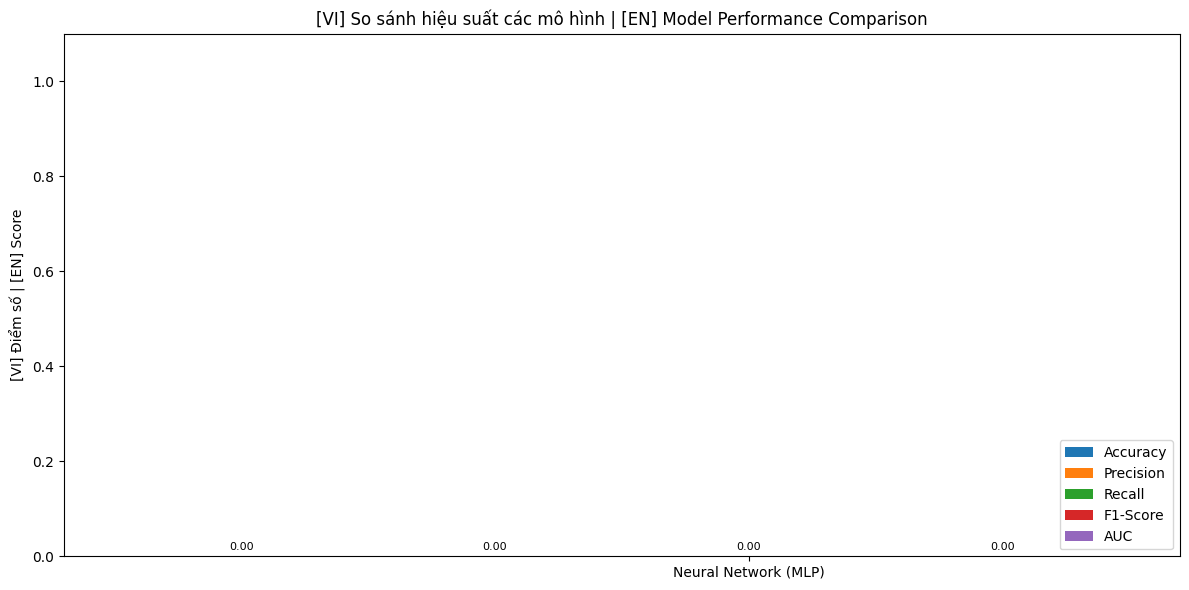

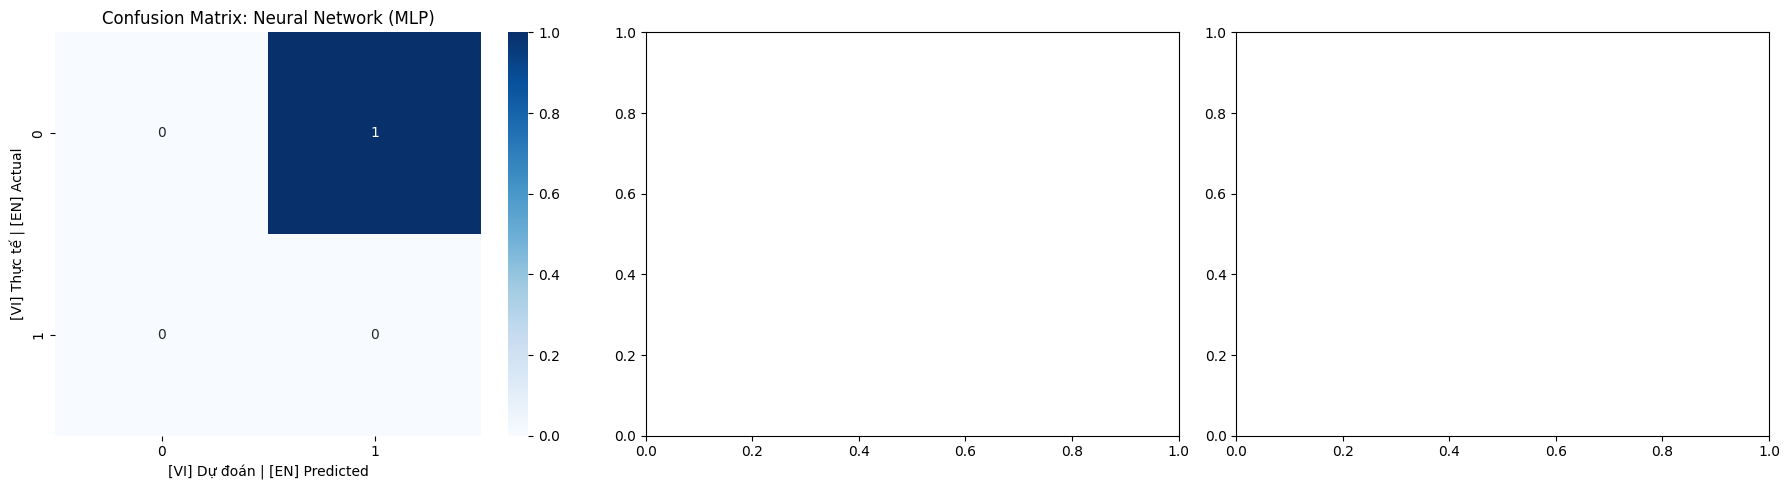


[VI] Mô hình tốt nhất (dựa trên F1-Score) là: Neural Network (MLP)
[EN] The best model (based on F1-Score) is: Neural Network (MLP)


In [8]:
# ============================================
# PART 3 2: TRAINING & INFERENCE PIPELINE (Colab)
# Phần 3: Huấn luyện & suy luận
# ============================================

# --- INSTALL & IMPORT ---
# [VI] Các thư viện cần thiết, giữ nguyên
# [EN] Necessary libraries, unchanged
!pip install -q sentence-transformers scikit-learn xgboost

import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # for saving models

# --------- Config: embedding model ----------
# [VI] Mô hình embedding, giữ nguyên
# [EN] Embedding model, unchanged
EMBED_MODEL = SentenceTransformer('all-MiniLM-L6-v2')

# ============================================
# Helper functions
# [VI] Giữ nguyên các hàm phụ trợ đã hoạt động tốt
# [EN] Keep the helper functions that are working well
# ============================================

def compute_skill_overlap(cv_skills, jd_skills):
    # [VI] Trả về số skill trùng và tỉ lệ trùng
    # [EN] Return matched_count, match_ratio
    set_cv = set([s.lower() for s in cv_skills])
    set_jd = set([s.lower() for s in jd_skills])
    matched = set_cv.intersection(set_jd)
    matched_count = len(matched)
    match_ratio = matched_count / (len(set_jd) + 1e-9)
    return matched_count, match_ratio, sorted(list(matched)), sorted(list(set_jd - set_cv))

def tfidf_cosine_similarity(text_a, text_b, vectorizer=None):
    # [VI] TF-IDF cosine similarity
    # [EN] TF-IDF cosine similarity
    if vectorizer is None:
        vectorizer = TfidfVectorizer(lowercase=True)
        X = vectorizer.fit_transform([text_a, text_b])
    else:
        X = vectorizer.transform([text_a, text_b])
    v0 = X[0].toarray()[0]
    v1 = X[1].toarray()[0]
    denom = (np.linalg.norm(v0) * np.linalg.norm(v1) + 1e-9)
    return float(np.dot(v0, v1)/denom), vectorizer

def embedding_similarity(text_a, text_b, model=EMBED_MODEL):
    # [VI] Sentence-transformer cosine similarity
    # [EN] Sentence-transformer cosine similarity
    emb_a = model.encode(text_a, convert_to_tensor=True)
    emb_b = model.encode(text_b, convert_to_tensor=True)
    sim = util.cos_sim(emb_a, emb_b).item()
    return float(sim)

def build_features_single(cv_text, cv_skills, jd_text, jd_skills, vectorizer=None):
    # [VI] Xây dựng vector đặc trưng cho một cặp CV-JD
    # [EN] Build feature vector for a single CV-JD pair
    num_skills_cv = len(cv_skills)
    num_skills_jd = len(jd_skills)
    matched_count, match_ratio, matched_list, missing_list = compute_skill_overlap(cv_skills, jd_skills)
    tfidf_sim, vectorizer = tfidf_cosine_similarity(" ".join(cv_skills) + " " + cv_text,
                                                    " ".join(jd_skills) + " " + jd_text,
                                                    vectorizer=vectorizer)
    emb_sim = embedding_similarity(cv_text, jd_text)
    cv_len_tokens = len(re.findall(r'\w+', cv_text))
    jd_len_tokens = len(re.findall(r'\w+', jd_text))

    features = {
        "num_skills_cv": num_skills_cv,
        "num_skills_jd": num_skills_jd,
        "matched_count": matched_count,
        "match_ratio": match_ratio,
        "tfidf_sim": tfidf_sim,
        "emb_sim": emb_sim,
        "cv_len_tokens": cv_len_tokens,
        "jd_len_tokens": jd_len_tokens,
    }
    meta = {"matched_list": matched_list, "missing_list": missing_list}
    return features, vectorizer, meta

# ============================================
# Main Pipeline: TRAINING & EVALUATION
# [VI] Pipeline chính: HUẤN LUYỆN & ĐÁNH GIÁ
# ============================================

def train_and_evaluate_models(X, y, models, test_size=0.4):
    """
    [VI] Huấn luyện và đánh giá nhiều mô hình trên cùng một tập dữ liệu.
    [EN] Train and evaluate multiple models on the same dataset.
    """
    # [VI] Chuẩn hóa dữ liệu trước khi huấn luyện
    # [EN] Standardize the data before training
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # [VI] Giảm chiều dữ liệu bằng PCA (nếu cần)
    # [EN] Reduce data dimensionality with PCA (if needed)
    # PCA giúp mô hình Neural Network hoạt động tốt hơn với ít đặc trưng hơn
    # PCA helps the Neural Network model perform better with fewer features
    if X_scaled.shape[1] > 5: # Chỉ áp dụng PCA nếu có nhiều hơn 5 đặc trưng
        pca = PCA(n_components=0.95) # giữ lại 95% phương sai
        X_pca = pca.fit_transform(X_scaled)
        print(f"[VI] Áp dụng PCA: {X_scaled.shape[1]} -> {X_pca.shape[1]} chiều")
        print(f"[EN] Applied PCA: {X_scaled.shape[1]} -> {X_pca.shape[1]} dimensions")
        #X_train, X_test, y_train, y_test = train_test_split(
        #    X_pca, y, test_size=test_size, random_state=42, stratify=y
        #)

        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=test_size, random_state=42
        )
    else:
        #X_train, X_test, y_train, y_test = train_test_split(
        #    X_scaled, y, test_size=test_size, random_state=42, stratify=y
        #)
        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=test_size, random_state=42
        )

    results = {}
    for name, model in models.items():
        print(f"\n[VI] Huấn luyện mô hình: {name}...")
        print(f"[EN] Training model: {name}...")
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

            # [VI] Đánh giá
            # [EN] Evaluation
            accuracy = accuracy_score(y_test, y_pred)
            precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
            auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

            print(f"Accuracy: {accuracy:.4f}")
            print(classification_report(y_test, y_pred))

            results[name] = {
                "model": model,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "fscore": fscore,
                "auc": auc,
                "y_pred": y_pred,
                "y_test": y_test,
                "scaler": scaler,
                "pca": pca if 'pca' in locals() else None
            }
        except Exception as e:
            print(f"[VI] Lỗi khi huấn luyện mô hình {name}: {e}")
            print(f"[EN] Error training model {name}: {e}")

    return results

# ============================================
# VISUALIZATION FUNCTIONS
# [VI] CÁC HÀM TRỰC QUAN HÓA
# ============================================
def visualize_results(results):
    """
    [VI] Trực quan hóa các kết quả đánh giá của các mô hình.
    [EN] Visualize the evaluation results of the models.
    """
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
    model_names = list(results.keys())
    scores = {
        "Accuracy": [results[name]["accuracy"] for name in model_names],
        "Precision": [results[name]["precision"] for name in model_names],
        "Recall": [results[name]["recall"] for name in model_names],
        "F1-Score": [results[name]["fscore"] for name in model_names],
        "AUC": [results[name]["auc"] for name in model_names],
    }

    x = np.arange(len(model_names))
    width = 0.15

    fig, ax = plt.subplots(figsize=(12, 6))

    #
    for i, (metric, values) in enumerate(scores.items()):
        rects = ax.bar(x + (i - 2) * width, values, width, label=metric)
        autolabel(rects, ax)

    ax.set_ylabel("[VI] Điểm số | [EN] Score")
    ax.set_title("[VI] So sánh hiệu suất các mô hình | [EN] Model Performance Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend(loc='lower right')
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

def autolabel(rects, ax):
    """[VI] Ghi số lên đầu các cột | [EN] Attach a text label above each bar."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

def plot_confusion_matrix(y_true, y_pred, title, ax):
    """
    [VI] Vẽ ma trận nhầm lẫn
    [EN] Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("[VI] Dự đoán | [EN] Predicted")
    ax.set_ylabel("[VI] Thực tế | [EN] Actual")

# ============================================
# EXECUTION
# [VI] THỰC THI
# ============================================
# [VI] Giả định bạn đã có df_pairs từ phần trước
# [EN] Assuming you have df_pairs from the previous part
# (Code để tạo df_pairs đã có trong phần trước)
df_pairs = pd.DataFrame([
    {
        "cv_text": """Fresher Mobile Developer experienced in Android, Java, Firebase, Git""",
        "cv_skills": ["react","javascript","css"],
        "jd_text": """Junior Mobile Developer required: Android, Java, Firebase, Git, Agile""",
        "jd_skills": ["android","java","firebase","git"],
        # optional label: 1 = good match, 0 = not match
        "label": 1
    },
    {
        "cv_text": """Frontend dev with React, JavaScript, CSS. No mobile experience.""",
        "cv_skills": ["react","javascript","css"],
        "jd_text": """Mobile Developer: Android, Java, Firebase, Git""",
        "jd_skills": ["android","java","firebase","git"],
        "label": 0
    },
], columns=["cv_text","cv_skills","jd_text","jd_skills","label"])



# [VI] Xây dựng features cho toàn bộ dữ liệu
# [EN] Build features for the entire dataset
feature_rows = []
vectorizer = None
metas = []
for _, row in df_pairs.iterrows():
    feats, vectorizer, meta = build_features_single(row.cv_text, row.cv_skills, row.jd_text, row.jd_skills, vectorizer=vectorizer)
    feature_rows.append(feats)
    metas.append(meta)

X = pd.DataFrame(feature_rows)
y = df_pairs['label'].values

print("[VI] Bảng features sau khi trích xuất:")
print("[EN] Features table after extraction:")
display(X.head())

# [VI] Định nghĩa các mô hình bạn đã học
# [EN] Define the models you have studied
models_to_test = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42),
}

# [VI] Huấn luyện và đánh giá
# [EN] Train and evaluate
if 'label' in df_pairs.columns and len(np.unique(y)) > 1:
    evaluation_results = train_and_evaluate_models(X, y, models_to_test)

    # [VI] Trực quan hóa kết quả tổng quát
    # [EN] Visualize overall results
    visualize_results(evaluation_results)

    # [VI] Trực quan hóa chi tiết từng mô hình (ma trận nhầm lẫn)
    # [EN] Visualize detailed results for each model (confusion matrix)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (name, res) in enumerate(evaluation_results.items()):
        plot_confusion_matrix(res['y_test'], res['y_pred'], f"Confusion Matrix: {name}", axes[i])
    plt.tight_layout()
    plt.show()

    # [VI] Lưu mô hình và scaler tốt nhất
    # [EN] Save the best model and scaler
    best_model_name = max(evaluation_results, key=lambda k: evaluation_results[k]['fscore'])
    best_model = evaluation_results[best_model_name]['model']
    best_scaler = evaluation_results[best_model_name]['scaler']
    best_pca = evaluation_results[best_model_name]['pca']
    joblib.dump(best_model, 'best_model.pkl')
    joblib.dump(best_scaler, 'scaler.pkl')
    if best_pca:
        joblib.dump(best_pca, 'pca.pkl')

    print(f"\n[VI] Mô hình tốt nhất (dựa trên F1-Score) là: {best_model_name}")
    print(f"[EN] The best model (based on F1-Score) is: {best_model_name}")
else:
    print("[VI] Không đủ dữ liệu nhãn để huấn luyện mô hình.")
    print("[EN] Not enough labeled data to train the models.")

In [4]:
# ============================================
# PART 4: INTERVIEW QUESTION GENERATOR
# Tạo câu hỏi phỏng vấn dựa trên CV & JD (lọc trùng nghĩa)
# ============================================

import random
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer, util

# Load model embedding đa ngôn ngữ
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# 1. Request interview question (Ngữ cảnh)
candidate_skills = result["skills"]
print(candidate_skills)
job_required_skills = jd_result["skills"]
# 2. Get candidate profile (thông tin ứng viên)
candidate_profile = {
    "name": "Nguyễn Trung Kiên",
    "position_applied": "Mobile Developer",
    "skills": candidate_skills,
    "experience_years": 1
}

# 3. Question Bank (Ngân hàng câu hỏi mẫu)
question_bank = {
    "technical": [
        "Hãy giải thích sự khác nhau giữa {skill1} và {skill2}.",
        "Bạn sẽ tối ưu performance cho ứng dụng Android như thế nào?",
        "Làm sao để bảo mật API trong ứng dụng di động?",
        "Trình bày quy trình CI/CD với Git và Firebase.",
        "So sánh SQL và NoSQL, trường hợp nào bạn chọn mỗi loại?"
    ],
    "behavioral": [
        "Hãy kể về một lần bạn gặp khó khăn khi làm việc nhóm và cách bạn giải quyết.",
        "Bạn sẽ xử lý thế nào khi deadline bị rút ngắn?",
        "Kể về một dự án mà bạn tự hào nhất và vai trò của bạn."
    ],
    "situational": [
        "Nếu khách hàng yêu cầu tính năng mới ngay trước ngày release, bạn sẽ làm gì?",
        "Nhóm bạn vừa deploy bản mới và phát hiện bug nghiêm trọng, bạn xử lý thế nào?"
    ]
}

# 4. Remove duplicates (text & semantic)
def remove_duplicates(questions, semantic_threshold=0.85):
    # Loại trùng text
    questions = list(dict.fromkeys(questions))

    # Loại trùng nghĩa
    embeddings = model.encode(questions, convert_to_tensor=True)
    keep = []
    for idx, q in enumerate(questions):
        if all(util.cos_sim(embeddings[idx], embeddings[k]) < semantic_threshold for k in keep):
            keep.append(idx)
    return [questions[i] for i in keep]

# 5. Personalize Questions
def personalize_questions(candidate_profile, job_required_skills, question_bank, n_questions=12):
    matched_skills = list(set(candidate_profile["skills"]) & set(job_required_skills))
    missing_skills = list(set(job_required_skills) - set(candidate_profile["skills"]))

    questions = []

    # Ưu tiên câu hỏi liên quan kỹ năng thiếu
    for skill in missing_skills:
        questions.append(f"Bạn chưa có nhiều kinh nghiệm với {skill}. Hãy cho biết cách bạn sẽ học nhanh công nghệ này.")

    # Câu hỏi kỹ thuật liên quan kỹ năng có
    for skill in matched_skills:
        q_template = random.choice(question_bank["technical"])
        if "{skill1}" in q_template and "{skill2}" in q_template:
            other_skill = random.choice([s for s in matched_skills if s != skill] or [skill])
            q_filled = q_template.format(skill1=skill, skill2=other_skill)
        else:
            q_filled = q_template
        questions.append(q_filled)

    # Thêm câu hỏi hành vi & tình huống
    questions.extend(random.sample(question_bank["behavioral"], k=2))
    questions.extend(random.sample(question_bank["situational"], k=2))

    # Lọc trùng text + trùng nghĩa
    questions = remove_duplicates(questions)

    # Giới hạn số lượng câu hỏi
    return questions[:n_questions]

# 6. Generate & show questions
interview_questions = personalize_questions(candidate_profile, job_required_skills, question_bank)
print("📋 Bộ câu hỏi phỏng vấn (đã lọc trùng):")
for i, q in enumerate(interview_questions, 1):
    print(f"{i}. {q}")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

['c#', 'database', 'git', 'go', 'postgresql', 'sql']
📋 Bộ câu hỏi phỏng vấn (đã lọc trùng):
1. Bạn chưa có nhiều kinh nghiệm với aws. Hãy cho biết cách bạn sẽ học nhanh công nghệ này.
2. Bạn chưa có nhiều kinh nghiệm với mysql. Hãy cho biết cách bạn sẽ học nhanh công nghệ này.
3. Bạn chưa có nhiều kinh nghiệm với version control. Hãy cho biết cách bạn sẽ học nhanh công nghệ này.
4. Bạn chưa có nhiều kinh nghiệm với java. Hãy cho biết cách bạn sẽ học nhanh công nghệ này.
5. Bạn chưa có nhiều kinh nghiệm với android. Hãy cho biết cách bạn sẽ học nhanh công nghệ này.
6. Bạn chưa có nhiều kinh nghiệm với mongodb. Hãy cho biết cách bạn sẽ học nhanh công nghệ này.
7. Bạn chưa có nhiều kinh nghiệm với swift. Hãy cho biết cách bạn sẽ học nhanh công nghệ này.
8. Hãy giải thích sự khác nhau giữa git và database.
9. Làm sao để bảo mật API trong ứng dụng di động?
10. Trình bày quy trình CI/CD với Git và Firebase.
11. Hãy kể về một lần bạn gặp khó khăn khi làm việc nhóm và cách bạn giải quyết.
12. 